In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def d_t(x, y):
    return (np.linalg.norm(x - y))**2

In [32]:
def epsilon_schedule(t=0): return 0.1 # return 1 / (1 + t)
def alpha_schedule(t=0): return 0.01
def rho_schedule(i=0): return 1.0

In [41]:
def prob_p_kji(N, M):
    p_kji = np.full((N, M, M), 0.2 / (M - 1))  # Default: uniform for k ≠ j

    for i in range(N):
        for j in range(M):
            p_kji[i, j, j] = 0.8  # Set p(k = j | j, i)

    return p_kji

In [42]:
def reinforcement_clustering(beta_min, beta_max, tau, M, X, max_outer_iter=100, max_inner_iter=100):
    N, d = X.shape
    beta = beta_min
    pi = np.full((N, M), 1 / M)
    centroid = np.mean(X, axis=0)
    Y = np.tile(centroid, (M, 1))  # Duplicate the centroid M times
    d_bar = np.zeros((N, M))

    t = 0  # time step (used for schedules)

    while beta <= beta_max:
        for _ in range(max_outer_iter):  # Outer convergence loop
            i = np.random.randint(N)
            j = np.random.choice(M, p=pi[i])
            prob = prob_p_kji(N,M)
            k = np.random.choice(M, p=prob[i,j,:])  

            eps = epsilon_schedule(t)
            d_bar[i, j] = eps * d_t(X[i], Y[j]) + (1 - eps) * d_t(X[i], Y[k])

        pi = np.exp(-beta * d_bar)
        pi /= pi.sum(axis=1, keepdims=True)

        for _ in range(max_inner_iter):  # Inner convergence loop
            for l in range(M):
                for i in range(N):
                    for j in range(M):
                        k = np.random.choice(M, p=prob[i,j,:])
                        alpha = alpha_schedule(t)
                        rho = rho_schedule(i)
                        delta = 1 if l == k else 0
                        pi_ji = pi[i, j]

                        Y[l] -= alpha * rho * pi_ji * (Y[k] - X[i]) * delta

            t += 1  # increment time step
        beta *= tau  # annealing

    return pi, Y


In [43]:
# Example synthetic data
X = np.vstack([
    np.random.randn(50, 2) + np.array([2, 2]),
    np.random.randn(50, 2) + np.array([-2, -2])
])

beta_min = 0.01
beta_max = 20.0
tau = 1.1
M = 2  # number of clusters

pi_star, Y_final = reinforcement_clustering(beta_min, beta_max, tau, M, X)

print("Final Centroids (Y):")
print(Y_final)

Final Centroids (Y):
[[-1.16887561 -1.20464215]
 [ 0.7994796   0.53940343]]


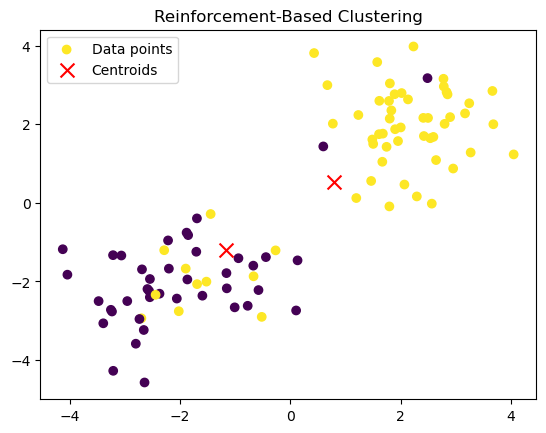

In [44]:
assignments = np.argmax(pi_star, axis=1)

plt.scatter(X[:, 0], X[:, 1], c=assignments, cmap='viridis', label='Data points')
plt.scatter(Y_final[:, 0], Y_final[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("Reinforcement-Based Clustering")
plt.legend()
plt.show()